In [1]:
%matplotlib notebook
import os, os.path
import pickle
import matplotlib
#matplotlib.use('agg')
import numpy
from scipy import integrate, interpolate
from optparse import OptionParser
from galpy.util import bovy_conversion
import gd1_util
from gd1_util import R0,V0
from scipy.integrate import quad
from scipy.optimize import brentq
from galpy.util import bovy_conversion, bovy_coords, save_pickles, bovy_plot
from galpy.potential import MWPotential2014, turn_physical_off, vcirc
import astropy.units as u
#%pylab inline
from galpy.orbit import Orbit
from numpy.polynomial import Polynomial
from gd1_util_MWhaloshape import lb_to_phi12
import numpy as np
import matplotlib.pyplot as plt

In [15]:
ro=8.
vo=220.

def compute_obs_density(phi1,apars,dens_apar,Omega):
    
    apar_edge=[]
    phi1_edge=[]

    abw0=apars[1]-apars[0]
    apar_edge.append(apars[0]-(abw0/2.))

    phi1bw0=phi1[1]-phi1[0]
    phi1_edge.append(phi1[0]-(phi1bw0/2.))

    for ii in range(len(apars)-1):
        abw=apars[ii+1]-apars[ii]
        phi1bw=phi1[ii+1]-phi1[ii]
        apar_edge.append(apars[ii]+abw/2.)
        phi1_edge.append(phi1[ii]+phi1bw/2.)

    abw_last=apars[len(apars)-1]-apars[len(apars)-2]
    apar_edge.append(apars[len(apars)-1]+(abw_last/2.))

    phi1bw_last=phi1[len(phi1)-1]-phi1[len(phi1)-2]
    phi1_edge.append(phi1[len(phi1)-1]+(phi1bw_last/2.))

    #compute the Jacobian d(apar)/d(phi1) using finite difference method
    dapar_dphi1=np.fabs(numpy.diff(apar_edge)/numpy.diff(phi1_edge))
    #print (dapar_dphi1)
   
    #Interpolate dens(apar)
    ipdens_apar= interpolate.InterpolatedUnivariateSpline(apars,dens_apar)

    #Interpolate apar(phi1)
    if phi1[1] < phi1[0] : # ad-hoc way of checking whether increasing or decreasing
        ipphi1= interpolate.InterpolatedUnivariateSpline(phi1[::-1],apars[::-1])
        #Interpolate Jacobian
        ipdapar_dphi1=interpolate.InterpolatedUnivariateSpline(phi1[::-1],dapar_dphi1[::-1])
        #Interpolate density(phi1) by multiplying by jacobian
        dens_phi1=interpolate.InterpolatedUnivariateSpline(phi1[::-1],ipdens_apar(ipphi1(phi1[::-1]))*ipdapar_dphi1(phi1[::-1]))
        
    else :
        ipphi1= interpolate.InterpolatedUnivariateSpline(phi1,apars)
        #Interpolate Jacobian
        ipdapar_dphi1=interpolate.InterpolatedUnivariateSpline(phi1,dapar_dphi1)
        #Interpolate density(phi1) by multiplying by jacobian
        dens_phi1=interpolate.InterpolatedUnivariateSpline(phi1,ipdens_apar(ipphi1(phi1))*ipdapar_dphi1(phi1))
       
    return (dens_phi1(phi1))


def compute_dens_cont(phi1,dens_phi1,outphi1,deg=3):
    if phi1[1] < phi1[0]:
        ip_dens_phi1=interpolate.InterpolatedUnivariateSpline(phi1[::-1],dens_phi1[::-1])

    else:
        ip_dens_phi1=interpolate.InterpolatedUnivariateSpline(phi1,dens_phi1)

    #compute polynomial and density at outphi1
    ppdens_phi1= Polynomial.fit(outphi1,ip_dens_phi1(outphi1),deg=deg)

    #compute density contrast
    dens_cont=ip_dens_phi1(outphi1)/ppdens_phi1(outphi1)
    
    return (outphi1,dens_cont)

def parse_times(times,age,ro=ro,vo=vo):
    if 'sampling' in times:
        nsam= int(times.split('sampling')[0])
        return [float(ti)/bovy_conversion.time_in_Gyr(vo,ro)
                for ti in numpy.arange(1,nsam+1)/(nsam+1.)*age]
    return [float(ti)/bovy_conversion.time_in_Gyr(vo,ro)
            for ti in times.split(',')]

def get_data(arm='trailing',poly_deg=3,gap_width=12.):
    
    #load's deBoer's data after selecting between phi1_min and phi1_max
    #
    gaia_dat=np.genfromtxt('fromDenis/GD1_stream_track_density_uncorr.dat',names=True)
    midphi1=gaia_dat['phi1mid']
    lin_den = gaia_dat['lindens']
    elin_den=gaia_dat['e_lindens']
    phi2=gaia_dat['phi2']
    ephi2=gaia_dat['e_phi2']

    print (min(midphi1),max(midphi1))
    
    if arm == 'leading' :
        phi1_min=-60.
        phi1_max=-40 -(gap_width*0.5)  #-42. 
        
    else :
        phi1_min=-40 +(gap_width*0.5) 
        phi1_max=10. #-4. #adjusted to match extent considered by Joeri  
        
    phi1_cut = midphi1[(midphi1 <= phi1_max) & (midphi1 >= phi1_min)]
    lin_den_cut = lin_den[(midphi1 <= phi1_max) & (midphi1 >= phi1_min)]
    elin_den_cut = elin_den[(midphi1 <= phi1_max) & (midphi1 >= phi1_min)]
    phi2_cut = phi2[(midphi1 <= phi1_max) & (midphi1 >= phi1_min)]
    ephi2_cut = ephi2[(midphi1 <= phi1_max) & (midphi1 >= phi1_min)]
    
    #fit 3rd order polynomial
    pp= Polynomial.fit(phi1_cut,lin_den_cut,deg=poly_deg,w=1/(elin_den_cut))  #for linear density
    pp_phi2= Polynomial.fit(phi1_cut,phi2_cut,deg=poly_deg,w=1/(ephi2_cut))   # for track
    
    #normalize density, track and errors
    norm_den = lin_den_cut/pp(phi1_cut)
    norm_den_err = elin_den_cut/pp(phi1_cut)
    norm_phi2_cut= phi2_cut - pp_phi2(phi1_cut)
    
    return (phi1_cut,phi2_cut,norm_den,norm_den_err,norm_phi2_cut,ephi2_cut)  

def compute_pk_data(arm='trailing',gap_width=12.):
    
    # get the data, "arm" incorporates the phi1 cuts           
    phi1,_,norm_den,norm_den_err,_,_=get_data(arm=arm,poly_deg=3,gap_width=gap_width)
    print (len(phi1))   
    px_dat,py_dat= signal.csd(norm_den,norm_den,fs=1./(phi1[1]-phi1[0]),scaling='spectrum',nperseg=len(phi1))
    py_dat= py_dat.real
    px_dat= 1./px_dat
    py_dat= numpy.sqrt(py_dat*(phi1[-1]-phi1[0]))
           
    # Perform simulations of the noise to determine the power in the noise
    nerrsim= 10000
    ppy_err_dat= numpy.empty((nerrsim,len(px_dat)))

    ppy_noise=numpy.empty((nerrsim,len(px_dat)))

    for ii in range(nerrsim):
        tmock= norm_den_err*numpy.random.normal(size=len(phi1))
        tmock_noise= norm_den + norm_den_err*numpy.random.normal(size=len(phi1))
        ppy_err_dat[ii]= signal.csd(tmock,tmock,
                                fs=1./(phi1[1]-phi1[0]),scaling='spectrum',
                                nperseg=len(phi1))[1].real

        ppy_noise[ii]= signal.csd(tmock_noise,tmock_noise,
                                fs=1./(phi1[1]-phi1[0]),scaling='spectrum',
                                nperseg=len(phi1))[1].real

    py_err_dat= numpy.sqrt(numpy.median(ppy_err_dat,axis=0)*(phi1[-1]-phi1[0]))

    ppy_noise_median = numpy.sqrt(numpy.nanmedian(ppy_noise,axis=0)*(phi1[-1]-phi1[0]))
    #print (ppy_noise_median- py_dat)

    ppy_noise.sort(axis=0)

    ppy_noise_low = numpy.sqrt(ppy_noise[int(numpy.round(0.023*nerrsim))]*(phi1[-1]-phi1[0]))
    ppy_noise_high = numpy.sqrt(ppy_noise[int(numpy.round(0.977*nerrsim))]*(phi1[-1]-phi1[0]))
    
    return (px_dat,ppy_noise_median,ppy_noise_low,ppy_noise_high,py_err_dat)

def set_ranges_and_labels_dens():
    #bovy_plot.bovy_text(r'$\sqrt{\delta\delta}$',top_left=True,size=18.)
    xlabel(r'$1/k_{\phi_{1}}\,(\mathrm{deg})$')
    ylabel(r'$\sqrt{P_{\delta\delta}(k_{\phi_{1}})}$')
    ylim(0.01,20.)
    xlim(1.,100.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    return None  



## Generate smooth stream and peppered stream with 1 impact (just for converting sim -->obs density)

In [3]:
#generate smooth stream and peppered stream

td = 4.
new_orb_lb=[188.04928416766532, 51.848594007807456, 7.559027173643999, 12.260258757214746, -5.140630283489461, 7.162732847549563]
isob=0.45
            
timpacts= parse_times("1sampling",td,ro=ro,vo=ro)


sigv_age=numpy.round((0.3*3.2)/td,2)
print ("velocity dispersion is set to %f"%sigv_age) 

#trailing arm
sdf_smooth=gd1_util.setup_gd1model(age=td,new_orb_lb=new_orb_lb,isob=isob,leading=False,sigv=sigv_age)    
sdf_pepper=gd1_util.setup_gd1model(timpact=timpacts,age=td,hernquist=True,new_orb_lb=new_orb_lb,isob=isob,leading=False,length_factor=1.,sigv=sigv_age)    
               

velocity dispersion is set to 0.240000


convert to physical density

<IPython.core.display.Javascript object>


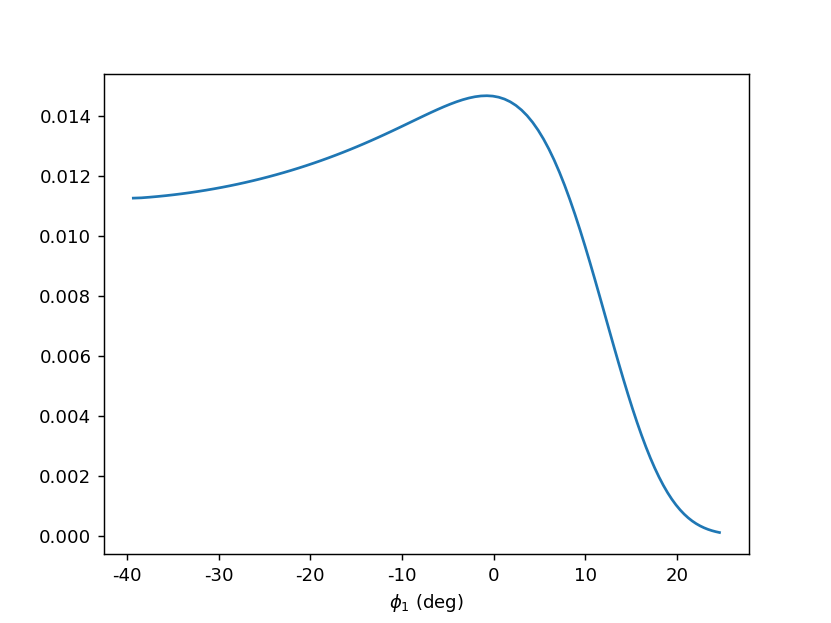

In [4]:
apars_out=np.arange(0.01,1.,0.01)

dens_unp= [sdf_smooth._density_par(a) for a in apars_out]
omega_unp= [sdf_smooth.meanOmega(a,oned=True) for a in apars_out]

mT= sdf_pepper.meanTrack(apars_out,_mO=omega_unp,coord='lb')
phi1=lb_to_phi12(mT[0],mT[1],degree=True)[:,0]
phi1[phi1 > 180.]-=360.
dens_phi1 = compute_obs_density(phi1,apars_out,dens_unp,omega_unp)

plt.figure()
plt.plot(phi1,dens_phi1)
plt.xlabel(r"$\phi_{1}$ (deg)")
plt.show()

Apply cuts and fit 3rd order polynomial

[-36 -34 -32 -30 -28 -26 -24 -22 -20 -18 -16 -14 -12 -10  -8  -6  -4  -2
   0   2   4   6   8]


<IPython.core.display.Javascript object>


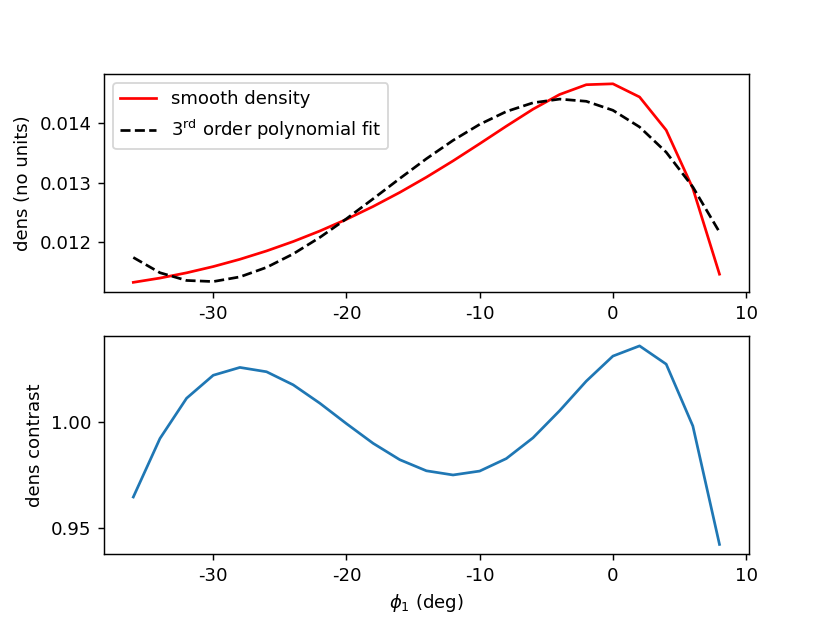

In [5]:
outphi1 = np.arange(-36,10,2)
print (outphi1)
#fit 3rd order spline 
ip_dens_phi1=interpolate.InterpolatedUnivariateSpline(phi1,dens_phi1)

ppdens_phi1= Polynomial.fit(outphi1,ip_dens_phi1(outphi1),deg=3)

outphi1,dens_cont = compute_dens_cont(phi1,dens_phi1,outphi1,deg=3)

plt.figure()
plt.subplot(2,1,1)
#plt.plot(outphi1,dens_cont)
plt.plot(outphi1,ip_dens_phi1(outphi1),c="r",label="smooth density")
plt.plot(outphi1,ppdens_phi1(outphi1),ls="--",c="k",label=r"$3^{\rm{rd}}$ order polynomial fit")
plt.ylabel("dens (no units)")
plt.legend(loc="upper left")

plt.subplot(2,1,2)
plt.plot(outphi1,dens_cont)
plt.ylabel("dens contrast")
plt.xlabel(r"$\phi_{1}$ (deg)")
plt.show()

-90.0 30.0
23
/home/nil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: divide by zero encountered in true_divide

/home/nil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """



<IPython.core.display.Javascript object>


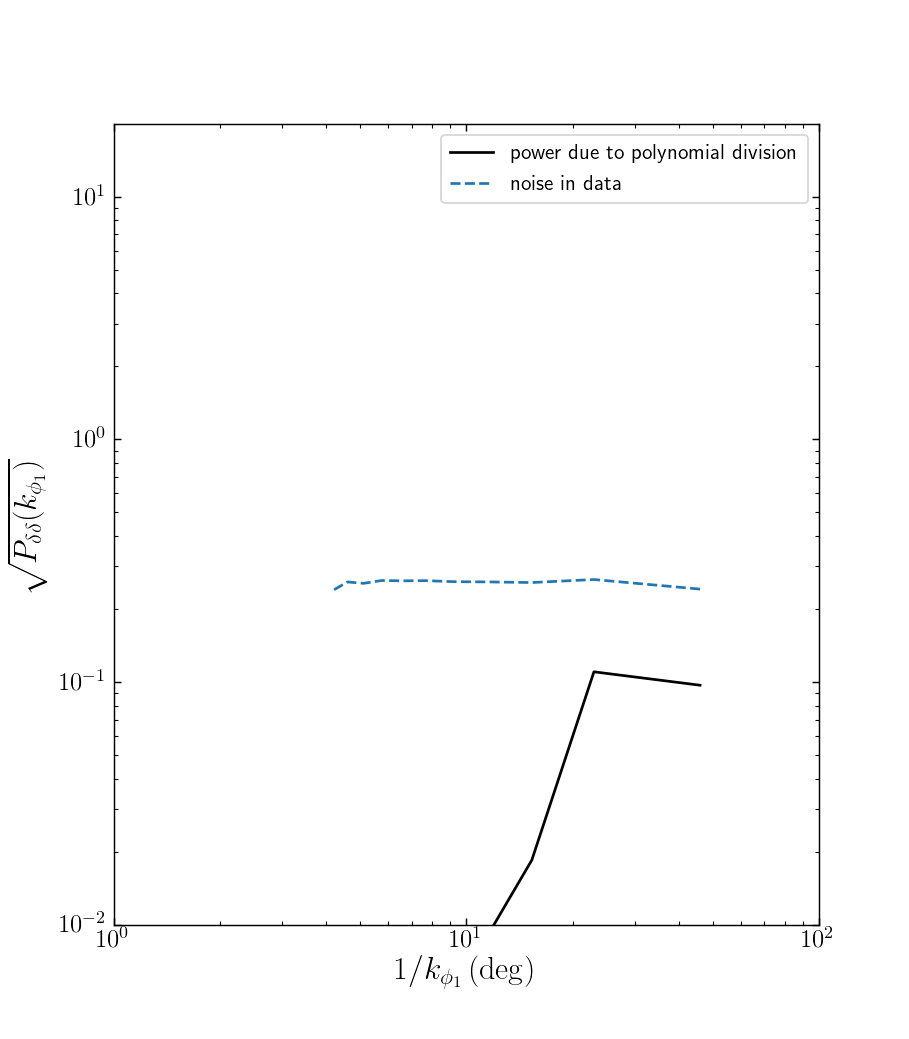

(1.0, 100.0)

In [20]:
from scipy import ndimage, signal, interpolate
def Pk_data(phi1,norm_den):
    px_dat,py_dat= signal.csd(norm_den,norm_den,fs=1./(phi1[1]-phi1[0]),scaling='spectrum',nperseg=len(phi1))
    py_dat= py_dat.real
    px_dat= 1./px_dat
    py_dat= numpy.sqrt(py_dat*(phi1[-1]-phi1[0]))
           
    return (px_dat,py_dat)

px_dat,_,_,_,py_err_dat = compute_pk_data(arm='trailing',gap_width=12.)

px,py = Pk_data(outphi1,dens_cont)
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
plt.figure(figsize=(7,8))
plt.loglog(px,py,color='k',zorder=10,ls='-',label="power due to polynomial division")
plt.loglog(px_dat,py_err_dat,ls="--",label="noise in data")
plt.xlabel(r'$1/k_{\phi_{1}}\,(\mathrm{deg})$')
plt.ylabel(r'$\sqrt{P_{\delta\delta}(k_{\phi_{1}})}$')
plt.legend(loc="upper right")
plt.ylim(0.01,20.)
plt.xlim(1.,100.)